# Disparity Empirical Analysis, and other visualizations and data analysis

In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import pickle
import csv
from tqdm import tqdm
import torch
from typing import List, Dict, Any, Tuple


# add ../.. to the path (MIAE)
import sys
sys.path.append('../../')
from miae.utils.dataset_utils import dataset_split
from experiment.models import get_model

COLUMNWIDTH = 241.14749
COLUMNWIDTH_INCH = 0.01384 * COLUMNWIDTH
TEXTWIDTH = 506.295
TEXTWIDTH_INCH = 0.01384 * TEXTWIDTH

import matplotlib as mpl

# modify this to set up directory:
DATA_DIR = "data"

plt.style.use('seaborn-v0_8-paper')
# set fontsize
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=7)
plt.rc('font', size=7)       
plt.rc('axes', titlesize=8)    
plt.rc('axes', labelsize=8)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

mia_name_mapping = {"losstraj": "losstraj", "shokri": "Class-NN", "yeom": "LOSS", "lira": "LiRA", "aug": "aug", "calibration": "calibrated-loss", "reference": "reference"}
mia_color_mapping = {"losstraj": '#1f77b4', "shokri": '#ff7f0e', "yeom": '#2ca02c', "lira": '#d62728', "aug": '#9467bd', "calibration": '#8c564b', "reference": '#e377c2'}


In [2]:
def is_empth_dir(path):
    return len([name for name in os.listdir(path)]) == 0

def dir_has_the_files(path, files):
    return all([os.path.exists(f"{path}/{f}") for f in files])

In [3]:
"""select which task to perform"""
"""
Task 1: Show training and testing accuracy for all target we have
Task 2: Loss Distribution
Task 3: PCA on target model logits
Task 4: Trend of pairwise similarity
Task 5: Trend of pairwise similarity with respect to the number of samples
"""
task = 4

In [4]:
# -- preload data
from typing import Tuple, Dict
from experiment.models import get_model
from typing import Dict, List
from miae.eval_methods.prediction import Predictions


if task in [2, 3, 5]:
    mias = ["losstraj", "shokri", "yeom", "aug", "calibration", "lira", "reference"]
    seeds = [0, 1, 2, 3 ,4, 5]
    device = torch.device("cuda:0")
    dataset = "cifar10"
    model = "resnet56"
    pred_path = f'{DATA_DIR}/miae_standard_exp'
    target_data_path = f'{DATA_DIR}/miae_standard_exp/target/{dataset}'
    stability_path = f"{pred_path}/stability_results"  # path to store the stability results as pkl files
    if not os.path.exists(stability_path):
        os.makedirs(stability_path)

    fpr = 0.1
    def mia_pred_unique(pred_dict: Dict[str, np.array]) -> dict[np.array]:
        """
        Get the unique prediction of the MIA
        """
        unique_pred_dict = dict()
        for i in (pred_dict.keys()):
            pred_i = pred_dict[i]
            other_attack_pred = np.zeros_like(pred_i)
            for j in pred_dict.keys():  # iterate over all other attacks
                if j != i:
                    np.logical_or(other_attack_pred, pred_dict[j], out=other_attack_pred)
            
            # unique_pred = pred_i and not other_attack_pred
            unique_pred = np.logical_and(pred_i, np.logical_not(other_attack_pred))
            unique_pred_dict[i] = unique_pred

        return unique_pred_dict


    # -- loading membership prediction and ground truth

    with open(f"{target_data_path}/attack_set_membership.npy", 'rb') as f:
        gt = np.load(f)

    if not dir_has_the_files(stability_path, f"mia_pred_TP_intersection_fpr{fpr}.pkl"):   
        mia_pred_dict = {} # prediction of different MIA
        for mia in mias:
            mia_pred_dict[mia] = {}
            for seed in seeds:
                with open(f"{pred_path}/preds_sd{seed}/{dataset}/{model}/{mia}/pred_{mia}.npy", 'rb') as f:
                    mia_pred = np.load(f)
                mia_pred_dict[mia][seed] = Predictions(mia_pred, gt, f"{mia}_sd{seed}").adjust_fpr(fpr)

        mia_pred_TP = {} # true positive of different MIA
        for mia in mias:
            mia_pred_TP[mia] = {}
            for seed in seeds: # mia_pred_TP[mia][seed][i] == 1 means the i-th data point is correctly predicted as a member
                mia_pred_TP[mia][seed] = np.array(mia_pred_dict[mia][seed]) == gt

        mia_pred_TN = {} # true negative of different MIA
        for mia in mias:
            mia_pred_TN[mia] = {}
            for seed in seeds: # mia_pred_TN[mia][seed][i] == 1 means the i-th data point is correctly predicted as a non-member
                mia_pred_TN[mia][seed] = np.array(mia_pred_dict[mia][seed]) != gt

        mia_pred_TP_intersection = {} # intersection of TP of each MIA across different seeds
        for mia in mias:
            mia_pred_TP_intersection[mia] = np.array([mia_pred_TP[mia][seed] for seed in seeds]).all(axis=0)

        mia_pred_TN_intersection = {} # intersection of TN of each MIA across different seeds
        for mia in mias:
            mia_pred_TN_intersection[mia] = np.array([mia_pred_TN[mia][seed] for seed in seeds]).all(axis=0)

        # -- get the TP and TN from different attacks
        mia_pred_TP_intersection_unique = mia_pred_unique(mia_pred_TP_intersection)
        mia_pred_TN_intersection_unique = mia_pred_unique(mia_pred_TN_intersection)

        # -- write both intersection to pkl
        with open(f"{stability_path}/mia_pred_TP_intersection_fpr{fpr}.pkl", 'wb') as f:
            pickle.dump(mia_pred_TP_intersection, f)
        with open(f"{stability_path}/mia_pred_TP_intersection_unique_fpr{fpr}.pkl", 'wb') as f:
            pickle.dump(mia_pred_TP_intersection_unique, f)
        with open(f"{stability_path}/mia_pred_TN_intersection_fpr{fpr}.pkl", 'wb') as f:
            pickle.dump(mia_pred_TN_intersection, f)
        with open(f"{stability_path}/mia_pred_TN_intersection_unique_fpr{fpr}.pkl", 'wb') as f:
            pickle.dump(mia_pred_TN_intersection_unique, f)

            # -- loading target data and target model
    with open(f"{target_data_path}/target_trainset.pkl", 'rb') as f:
        target_train_data = pickle.load(f)
    with open(f"{target_data_path}/target_testset.pkl", 'rb') as f:
        target_test_data = pickle.load(f)

### Task 1: Show training and testing accuracy for all target we have

In [5]:
import csv

pred_path = f'{DATA_DIR}/repeat_miae_standard_exp'
save_path = f"{pred_path}/target_training_statsd.csv"
runs = [0, 1, 2, 3]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def accuracy(model, data, device):
    model.eval()
    correct = 0
    total = 0
    model.to(device)
    data_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=False)
    with torch.inference_mode():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    top1_accuracy = correct / total
    _, top3_predicted = torch.topk(outputs.data, 3, dim=1)
    top3_correct = torch.sum(top3_predicted == labels.unsqueeze(1)).item()
    top3_accuracy = top3_correct / total
    return top1_accuracy, top3_accuracy

def load_dataset_info(datset_name):
    """
    get the basic info for dataset
    :param datset_name: name of the dataset
    :return: number of classes and input size
    """
    if datset_name == "cifar10":
        num_classes = 10
        input_size = 32
    elif datset_name == "cifar100":
        num_classes = 100
        input_size = 32
    elif datset_name == "cinic10":
        num_classes = 10
        input_size = 32
    elif datset_name == "purchase100":
        num_classes = 100
        input_size = 600
    elif datset_name == "texas100":
        num_classes = 100
        input_size = 6169
    else:
        raise ValueError("Invalid dataset")

    return num_classes, input_size


def process_accuracy(arch, dataset, runs):
    num_classes, input_size = load_dataset_info(dataset)
    print (f"Number of classes: {num_classes}")
    if arch == "resnet56":
        target_model = get_model("resnet56", num_classes=num_classes, input_size=input_size)
    elif arch == "vgg16":
        target_model = get_model("vgg16", num_classes=num_classes, input_size=input_size)
    elif arch == "mobilenet":
        target_model = get_model("mobilenet", num_classes=num_classes, input_size=input_size)
    elif arch == "wrn32_4":
        target_model = get_model("wrn32_4", num_classes=num_classes, input_size=input_size)
    elif arch == "mlp_for_texas_purchase":
        target_model = get_model("mlp_for_texas_purchase", num_classes=num_classes, input_size=input_size)

    train_accuracies = []
    train_accuracies_top3 = []
    test_accuracies = []
    test_accuracies_top3 = []

    for run in runs:  
        target_path = os.path.join(pred_path, f"miae_standard_exp_{run}/target")
        target_model_path = f"{target_path}/target_models/{dataset}/{arch}/target_model_{arch}{dataset}.pkl"
        target_train_data_path = f"{target_path}/{dataset}/target_trainset.pkl"
        target_test_data_path = f"{target_path}/{dataset}/target_testset.pkl"

        target_model.load_state_dict(torch.load(target_model_path))
        with open(target_train_data_path, 'rb') as f:
            target_train_data = pickle.load(f)
        with open(target_test_data_path, 'rb') as f:
            target_test_data = pickle.load(f)

        train_acc_ret = accuracy(target_model, target_train_data, device)
        test_acc_ret = accuracy(target_model, target_test_data, device)

        train_accuracies.append(train_acc_ret[0])
        train_accuracies_top3.append(train_acc_ret[1])
        test_accuracies.append(test_acc_ret[0])
        test_accuracies_top3.append(test_acc_ret[1])

    avg_train_accuracy = np.mean(train_accuracies)
    std_train_accuracy = np.std(train_accuracies)
    avg_train_accuracy_top3 = np.mean(train_accuracies_top3)
    std_train_accuracy_top3 = np.std(train_accuracies_top3)
    avg_test_accuracy = np.mean(test_accuracies)
    std_test_accuracy = np.std(test_accuracies)
    avg_test_accuracy_top3 = np.mean(test_accuracies_top3)
    std_test_accuracy_top3 = np.std(test_accuracies_top3)
    generalization_gap = avg_train_accuracy - avg_test_accuracy
    generalization_gap_std = std_train_accuracy - std_test_accuracy


    # average accuracy, std
    print(f"Average train accuracy: {avg_train_accuracy*100:.4f}% ± {std_train_accuracy*100:.4f}%")
    print(f"Average test accuracy: {avg_test_accuracy*100:.4f}% ± {std_test_accuracy*100:.4f}%")
    print(f"Generalization gap: {generalization_gap*100:.4f}% ± {generalization_gap_std*100:.4f}%")

    return avg_train_accuracy, std_train_accuracy, avg_train_accuracy_top3, std_train_accuracy_top3, avg_test_accuracy, std_test_accuracy, avg_test_accuracy_top3, std_test_accuracy_top3, generalization_gap, generalization_gap_std

# arch_list = ["resnet56", "vgg16", "mobilenet", "wrn32_4"]
arch_list = ["mlp_for_texas_purchase"]
dataset_list = ["texas100", "purchase100"]

header = ['Architecture', 'Dataset', 'Avg Train Accuracy', 'Std Train Accuracy', 'Avg Test Accuracy', 'Std Test Accuracy', 'Generalization Gap', 'Generalization Gap Std']
if task == 1:
    with open(save_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)

    for arch in arch_list:
        for dataset in dataset_list:
            print(f"Processing {arch} on {dataset}")
            avg_train_accuracy, std_train_accuracy, avg_train_accuracy_top3, std_train_accuracy_top3, avg_test_accuracy, std_test_accuracy, avg_test_accuracy_top3, std_test_accuracy_top3, generalization_gap, generalization_gap_std = process_accuracy(arch, dataset, runs)
            
            with open(save_path, mode='a') as f:
                writer = csv.writer(f)
                writer.writerow([arch, dataset, avg_train_accuracy, std_train_accuracy, avg_test_accuracy, std_test_accuracy, generalization_gap, generalization_gap_std])
    print(f"csv saved to {save_path}")

### Task 2: loss distribution

In [6]:
dataset = "cifar100"
pred_path = f'{DATA_DIR}/miae_standard_exp'
target_data_path = f'{DATA_DIR}/miae_standard_exp/target/{dataset}'
stability_path = f"{pred_path}/stability_results"  # path to store the stability results as pkl files
fpr = 0.1

# y = "loss"
y = "logit_scale_conf"

import matplotlib as mpl


save_path = f"{pred_path}/y_distribution_analysis"

os.makedirs(save_path) if not os.path.exists(save_path) else None
os.makedirs(stability_path) if not os.path.exists(stability_path) else None
os.makedirs(f"{save_path}/tp") if not os.path.exists(f"{save_path}/tp") else None
os.makedirs(f"{save_path}/tn") if not os.path.exists(f"{save_path}/tn") else None
os.makedirs(f"{save_path}/tp/each_attack") if not os.path.exists(f"{save_path}/tp/each_attack") else None
os.makedirs(f"{save_path}/tn/each_attack") if not os.path.exists(f"{save_path}/tn/each_attack") else None
os.makedirs(f"{save_path}/tp/each_attack_unique") if not os.path.exists(f"{save_path}/tp/each_attack_unique") else None
os.makedirs(f"{save_path}/tn/each_attack_unique") if not os.path.exists(f"{save_path}/tn/each_attack_unique") else None

plt.style.use('seaborn-v0_8-paper')
# set fontsize
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=7)
plt.rc('font', size=7)       
plt.rc('axes', titlesize=8)    
plt.rc('axes', labelsize=8)

def get_loss(model, data, device) -> np.array:
    """
    Get the loss of the model on each data point
    """
    model.eval()
    model.to(device)
    data_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
    loss_array = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            loss_array.append(loss.item())
    return np.array(loss_array)

def get_logit_scale_conf(model, data, device) -> np.array:
    """
    Let the model confidence be p = f(x)_y, logit scaled confidence is log(p / (1 - p))
    """
    model.eval()
    model.to(device)
    data_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
    logit_scale_conf_array = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logit_scale_conf = torch.nn.functional.log_softmax(outputs, dim=1)[:, labels] - torch.nn.functional.log_softmax(outputs, dim=1)[:, 1 - labels]
            logit_scale_conf_array.append(logit_scale_conf.item())
    return np.array(logit_scale_conf_array)



with open(f"{target_data_path}/attack_set_membership.npy", 'rb') as f:
    gt = np.load(f)

if task == 2:
    target_model = get_model(model, num_classes=10, input_size=32)
    target_model.load_state_dict(torch.load(f"{pred_path}/target/target_models/{dataset}/{model}/target_model_{model}{dataset}.pkl"))

    # -- get the loss of the target model on the target data
    if not os.path.exists(f"{pred_path}/target/target_{y}.npy"):
        print(f"no target {y} found at {pred_path}/target/target_{y}.npy, calculating...")
        target_train_loss = get_loss(target_model, target_train_data, device) if y == "loss" else get_logit_scale_conf(target_model, target_train_data, device)
        target_test_loss = get_loss(target_model, target_test_data, device) if y == "loss" else get_logit_scale_conf(target_model, target_test_data, device)
        target_loss = np.concatenate([target_train_loss, target_test_loss])
        with open(f"{pred_path}/target/target_{y}.npy", 'wb') as f:
            np.save(f, target_loss)
        print(f"Target loss saved to {pred_path}/target/target_{y}.npy")
    else:
        with open(f"{pred_path}/target/target_{y}.npy", 'rb') as f:
            target_loss = np.load(f)
        print(f"Target loss loaded from {pred_path}/target/target_{y}.npy")

    # -- show loss distribution of samples
    plt.hist(target_loss, bins=50)
    plt.xlabel(y)
    plt.ylabel('Number of samples')
    plt.title(f'{y} distribution of samples')
    plt.yscale('log') if y == "loss" else None
    plt.show()

    with open(f"{stability_path}/mia_pred_TP_intersection_fpr{fpr}.pkl", 'rb') as f:
        mia_pred_TP_intersection = pickle.load(f)
    with open(f"{stability_path}/mia_pred_TP_intersection_unique_fpr{fpr}.pkl", 'rb') as f:
        mia_pred_TP_intersection_unique = pickle.load(f)
    with open(f"{stability_path}/mia_pred_TN_intersection_fpr{fpr}.pkl", 'rb') as f:
        mia_pred_TN_intersection = pickle.load(f)
    with open(f"{stability_path}/mia_pred_TN_intersection_unique_fpr{fpr}.pkl", 'rb') as f:
        mia_pred_TN_intersection_unique = pickle.load(f)


    def loss_hist(data, path, bins=50, alpha=0.5, color='b', label=None, format='pdf'):
        plt.figure(figsize=(COLUMNWIDTH_INCH, 2)) 
        plt.hist(data, bins=bins, alpha=alpha, color=color, label=label)
        plt.xlabel(y)
        plt.ylabel('Frequency')
        plt.legend()
        plt.yscale('log') if y == "loss" else None
        plt.tight_layout()
        plt.savefig(path, format=format)
        plt.close()

    def loss_hist_multiple_attack(loss_dict, data_dict, path, bins=50, alpha=0.5, format='pdf'):
        plt.figure(figsize=(COLUMNWIDTH_INCH, 2))
        for mia in data_dict.keys():
            plt.hist(loss_dict[data_dict[mia]], bins=bins, alpha=alpha, color=mia_color_mapping[mia], label=mia_name_mapping[mia])
        plt.xlabel(y)
        plt.ylabel('Frequency')
        plt.legend()
        plt.yscale('log') if y == "loss" else None
        plt.tight_layout()
        plt.savefig(path, format=format)
        plt.close()


    # -- plot the number of TP at different loss values. Each attack is a different color
    loss_hist_multiple_attack(target_loss, mia_pred_TP_intersection_unique, f"{save_path}/tp/{y}_vs_tp_fpr0.1.pdf")

    # -- plot the number of TP for each attack
    for I, mia in enumerate(mias):   
        loss_hist(target_loss[mia_pred_TP_intersection[mia]], f"{save_path}/tp/each_attack/{y}_vs_tp_fpr0.1_{mia}.pdf", alpha=0.5, color=mia_color_mapping[mia], label=mia_name_mapping[mia])
        loss_hist(target_loss[mia_pred_TP_intersection_unique[mia]], f"{save_path}/tp/each_attack_unique/{y}_vs_tp_fpr0.1_{mia}.pdf", alpha=0.5, color=mia_color_mapping[mia], label=mia_name_mapping[mia])


    # -- plot the number of TN at different loss values. Each attack is a different color
    loss_hist_multiple_attack(target_loss, mia_pred_TN_intersection_unique, f"{save_path}/tn/{y}_vs_tn_fpr0.1.pdf")

    # -- plot the number of TN for each attack
    for I, mia in enumerate(mias):  
        loss_hist(target_loss[mia_pred_TN_intersection[mia]], f"{save_path}/tn/each_attack/{y}_vs_tn_fpr0.1_{mia}.pdf", alpha=0.5, color=mia_color_mapping[mia], label=mia_name_mapping[mia])
        loss_hist(target_loss[mia_pred_TN_intersection_unique[mia]], f"{save_path}/tn/each_attack_unique/{y}_vs_tn_fpr0.1_{mia}.pdf", alpha=0.5, color=mia_color_mapping[mia], label=mia_name_mapping[mia])

    # -- save the config to a txt file
    with open(f"{save_path}/config.txt", 'w') as f:
        f.write(f"target model: {model}\n")
        f.write(f"target dataset: {dataset}\n")
        f.write(f"fpr: {fpr}\n")
        f.write(f"mias: {mias}\n")
        f.write(f"seeds: {seeds}\n")
        f.write(f"mia_pred_TP_intersection_unique: {mia_pred_TP_intersection_unique}\n")
        f.write(f"mia_pred_TN_intersection_unique: {mia_pred_TN_intersection_unique}\n")
        f.write(f"target_loss: {target_loss}\n")
        f.write(f"save_path: {save_path}\n")
        

    print(f"{y} distribution analysis saved to {save_path}")

### Task 3: PCA taget output distribution vs attacks

In [7]:
dataset = "cifar100"
model = "resnet56"
pred_path = f'{DATA_DIR}/miae_standard_exp'
target_data_path = f'{DATA_DIR}/miae_standard_exp/target/cifar100'
mias = ["losstraj", "shokri", "yeom", "aug", "calibration", "lira", "reference"]
seeds = [0, 1, 2, 3 ,4, 5]
device = torch.device("cuda:0")
fpr = 0.1

save_path = f"{pred_path}/pca_on_output_analysis"
os.makedirs(save_path) if not os.path.exists(save_path) else None
os.makedirs(f"{save_path}/tp") if not os.path.exists(f"{save_path}/tp") else None
os.makedirs(f"{save_path}/tp/single_attack_unique") if not os.path.exists(f"{save_path}/tp/single_attack_unique") else None
os.makedirs(f"{save_path}/tp/single_attack") if not os.path.exists(f"{save_path}/tp/single_attack") else None
os.makedirs(f"{save_path}/tn") if not os.path.exists(f"{save_path}/tn") else None
os.makedirs(f"{save_path}/tn/single_attack_unique") if not os.path.exists(f"{save_path}/tn/single_attack_unique") else None
os.makedirs(f"{save_path}/tn/single_attack") if not os.path.exists(f"{save_path}/tn/single_attack") else None

from experiment.models import get_model
from miae.eval_methods.prediction import Predictions
from sklearn.decomposition import PCA
import matplotlib as mpl

with open(f"{target_data_path}/attack_set_membership.npy", 'rb') as f:
    gt = np.load(f)

def get_pca(logits: np.ndarray, n_components: int) -> np.array:
    """
    Get the PCA of target model's logits on the target data
    """
    pca = PCA(n_components=n_components)
    pca.fit(logits)
    return pca

def get_logits(model, data, device) -> np.array:
    """
    Get the confidence scores of the model on each data point
    """
    model.eval()
    model.to(device)

    data_loader = torch.utils.data.DataLoader(data, batch_size=512, shuffle=False)
    logits = None
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).cpu().numpy()
            logits = outputs if logits is None else np.concatenate([logits, outputs], axis=0)
    return logits

if task == 3:
    with open(f"{stability_path}/mia_pred_TP_intersection_fpr{fpr}.pkl", 'rb') as f:
        mia_pred_TP_intersection = pickle.load(f)
    with open(f"{stability_path}/mia_pred_TP_intersection_unique_fpr{fpr}.pkl", 'rb') as f:
        mia_pred_TP_intersection_unique = pickle.load(f)
    with open(f"{stability_path}/mia_pred_TN_intersection_fpr{fpr}.pkl", 'rb') as f:
        mia_pred_TN_intersection = pickle.load(f)
    with open(f"{stability_path}/mia_pred_TN_intersection_unique_fpr{fpr}.pkl", 'rb') as f:
        mia_pred_TN_intersection_unique = pickle.load(f)
        
    target_model = get_model(model, num_classes=10, input_size=32)
    target_model.load_state_dict(torch.load(f"{pred_path}/target/target_models/{dataset}/{model}/target_model_{model}{dataset}.pkl"))

    # -- get the loss of the target model on the target data
    if not os.path.exists(f"{pred_path}/target/target_logits.npy"):
        print(f"no target logits found at {pred_path}/target/target_logits.npy, calculating...")
        target_train_logits = get_logits(target_model, target_train_data, device)
        target_test_logits = get_logits(target_model, target_test_data, device)
        target_logits = np.concatenate([target_train_logits, target_test_logits])
        with open(f"{pred_path}/target/target_logits.npy", 'wb') as f:
            np.save(f, target_logits)
        print(f"Target logits saved to {pred_path}/target/target_logits.npy")

    else:
        with open(f"{pred_path}/target/target_logits.npy", 'rb') as f:
            target_logits = np.load(f)
        print(f"Target logits loaded from {pred_path}/target/target_logits.npy")

    # -- show pca of all inputs (full pca, meaning for 10 classes, there are 10 principal components)
    full_pca = get_pca(target_logits, n_components=10)
    print(full_pca.explained_variance_ratio_)

    # -- show pca of all inputs 
    pca = get_pca(target_logits, n_components=3)
    target_pca = pca.transform(target_logits)
    target_pca_normed = (target_pca - target_pca.min(axis=0)) / (target_pca.max(axis=0) - target_pca.min(axis=0))
    print(f"The explained variance ratio of the first two components: {pca.explained_variance_ratio_}")
    # plot all samples in PCA space
    plt.figure(figsize=(COLUMNWIDTH_INCH, 2))
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.scatter(target_pca_normed[:, 0], target_pca_normed[:, 1])
    plt.tight_layout()
    plt.show()


    def plot_pca(pca1, pca2, path, color, format='pdf', alpha=0.7):
        plt.figure(figsize=(COLUMNWIDTH_INCH, 2))
        plt.scatter(pca1, pca2, c=color, alpha=alpha)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.savefig(path, format=format)
        plt.close()

    def plot_pca_multiple_attack(pca1, pca2, data_dict, path, format='pdf', alpha=0.5):
        plt.figure(figsize=(TEXTWIDTH_INCH, 5))
        for mia in data_dict.keys():
            plt.scatter(pca1[data_dict[mia]], pca2[data_dict[mia]], c=mia_color_mapping[mia], label=mia_name_mapping[mia], alpha=alpha)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.legend()
        plt.tight_layout()
        plt.savefig(path, format=format)
        plt.close()

    def plot_pca_3d(pca1, pca2, pca3, path, color, format='pdf', alpha=0.7):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pca1, pca2, pca3, c=color, alpha=alpha)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_zlim(0, 1)
        plt.tight_layout()
        plt.savefig(path, format=format)
        plt.close()

    def plot_pca_multiple_attack_3d(pca1, pca2, pca3, data_dict, path, format='pdf', alpha=0.5):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for mia in data_dict.keys():
            ax.scatter(pca1[data_dict[mia]], pca2[data_dict[mia]], pca3[data_dict[mia]], c=mia_color_mapping[mia], label=mia_name_mapping[mia], alpha=alpha)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        plt.legend()
        plt.tight_layout()
        plt.savefig(path, format=format)
        plt.close()



    # plot unique TP in PCA space
    for mia in mias:
        plot_pca(target_pca_normed[mia_pred_TP_intersection_unique[mia], 0], target_pca_normed[mia_pred_TP_intersection_unique[mia], 1], f"{save_path}/tp/single_attack_unique/mia_tp_{mia}.pdf", mia_color_mapping[mia])
        plot_pca(target_pca_normed[mia_pred_TP_intersection[mia], 0], target_pca_normed[mia_pred_TP_intersection[mia], 1], f"{save_path}/tp/single_attack/mia_tp_{mia}.pdf", mia_color_mapping[mia])
        plot_pca_3d(target_pca_normed[mia_pred_TP_intersection_unique[mia], 0], target_pca_normed[mia_pred_TP_intersection_unique[mia], 1], target_pca_normed[mia_pred_TP_intersection_unique[mia], 2], f"{save_path}/tp/single_attack_unique/mia_tp_{mia}_3d.pdf", mia_color_mapping[mia])
        plot_pca_3d(target_pca_normed[mia_pred_TP_intersection[mia], 0], target_pca_normed[mia_pred_TP_intersection[mia], 1], target_pca_normed[mia_pred_TP_intersection[mia], 2], f"{save_path}/tp/single_attack/mia_tp_{mia}_3d.pdf", mia_color_mapping[mia])

    # plot all samples in PCA space, color by different attacks
    plot_pca_multiple_attack(target_pca_normed[:, 0], target_pca_normed[:, 1], mia_pred_TP_intersection_unique, f"{save_path}/tp/mia_tp_all_unique.pdf", alpha=0.5)
    plot_pca_multiple_attack(target_pca_normed[:, 0], target_pca_normed[:, 1], mia_pred_TP_intersection, f"{save_path}/tp/mia_tp_all.pdf", alpha=0.3)
    plot_pca_multiple_attack_3d(target_pca_normed[:, 0], target_pca_normed[:, 1], target_pca_normed[:, 2], mia_pred_TP_intersection_unique, f"{save_path}/tp/mia_tp_all_unique_3d.pdf", alpha=0.5)
    plot_pca_multiple_attack_3d(target_pca_normed[:, 0], target_pca_normed[:, 1], target_pca_normed[:, 2], mia_pred_TP_intersection, f"{save_path}/tp/mia_tp_all_3d.pdf", alpha=0.3)



    # plot unique TN in PCA space
    for mia in mias:
        plot_pca(target_pca_normed[mia_pred_TN_intersection_unique[mia], 0], target_pca_normed[mia_pred_TN_intersection_unique[mia], 1], f"{save_path}/tn/single_attack_unique/mia_tn_{mia}.pdf", mia_color_mapping[mia])
        plot_pca(target_pca_normed[mia_pred_TN_intersection[mia], 0], target_pca_normed[mia_pred_TN_intersection[mia], 1], f"{save_path}/tn/single_attack/mia_tn_{mia}.pdf", mia_color_mapping[mia])

    # plot all samples in PCA space, color by different attacks
    plot_pca_multiple_attack(target_pca_normed[:, 0], target_pca_normed[:, 1], mia_pred_TN_intersection_unique, f"{save_path}/tn/mia_tn_all_unique.pdf", alpha=0.5)
    plot_pca_multiple_attack(target_pca_normed[:, 0], target_pca_normed[:, 1], mia_pred_TN_intersection, f"{save_path}/tn/mia_tn_all.pdf", alpha=0.3)

    print(f"pca_on_output_analysis saved at {save_path}")

### Task 4: Read the similarity report and plot trends

line plot saved to /home/data/wangz56/repeat_miae_standard_exp/jaccard_similarity_analysis/cifar100/resnet56/line_plot
scatter plot saved to /home/data/wangz56/repeat_miae_standard_exp/jaccard_similarity_analysis/cifar100/resnet56/scatter_plot


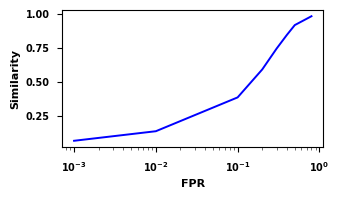

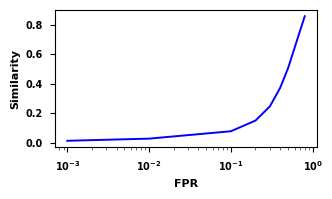

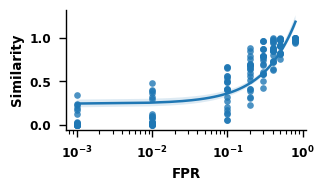

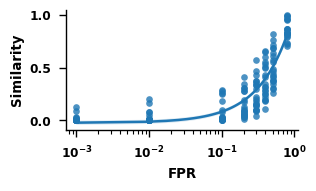

In [ ]:
import os
import csv
from matplotlib import pyplot as plt
from pandas import DataFrame as df
import seaborn as sns

dataset = "cifar10"
model = "resnet56"


path = f'{DATA_DIR}/repeat_miae_standard_exp/jaccard_similarity/{dataset}/{model}'
save_path = f'{DATA_DIR}/repeat_miae_standard_exp/jaccard_similarity_analysis/{dataset}/{model}'
save_path_line_plot = f'{DATA_DIR}/repeat_miae_standard_exp/jaccard_similarity_analysis/{dataset}/{model}/line_plot'
save_path_scatter_plot = f'{DATA_DIR}/repeat_miae_standard_exp/jaccard_similarity_analysis/{dataset}/{model}/scatter_plot'

for p in [save_path, save_path_line_plot, save_path_scatter_plot]:
    os.makedirs(p) if not os.path.exists(p) else None

fpr_dirs = [d for d in os.listdir(path) if '_' in d]
fprs = [float(sub_dir.split('_')[-1]) for sub_dir in fpr_dirs] # sub_directories are in the format of 'fpr_{fpr_valut}'
fprs.sort()

# scv header: "Process Option,Pair 1,Pair 2,Value"

def parse_avg_std(a) -> Tuple[float, float]:
    a = a.split('±')
    return float(a[0]), float(a[1])

def parse_pairs(a1, a2) -> str:
    """
    given 2 pairs of attack string, extract the attack name, sort, and return a combined string.
    Since the returned pair string is sorted, it can be used as a key in a dictionary.
    ie: parse_pairs('Class-NN_Coverage', "LOSS_Coverage") == "class-NN_LOSS"
    """

    a1 = a1.split('_')
    a2 = a2.split('_')
    if len(a1) != 2 or len(a2) != 2:
        raise ValueError('Invalid pair format: {}, {}'.format(a1, a2))
    return '_'.join(sorted([a1[0], a2[0]])).lower()


# -- line plot of avg of avg and std of avg for each fpr
def plot_avg_avg_std_avg(fprs, similarities_dict, save_path, y_label, format='pdf'):
    plt.figure(figsize=(COLUMNWIDTH_INCH, 2))
    avg_avg, avg_std = [], [] # average of average and std of average
    for fpr in fprs:
        avg_avg.append(np.mean([v[0] for v in similarities_dict[fpr].values()]))
        avg_var = [v[1] for v in similarities_dict[fpr].values()] - avg_avg[-1]
        avg_std.append(np.sqrt(np.mean(np.square(avg_var))))


    plt.plot(fprs, avg_avg, 'b-')
    plt.xlabel('FPR')
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.tight_layout()
    plt.savefig(save_path, format=format)

# -- plot scatter plot of all pairs' similarity at each fpr
def plot_similarity_scatter_plot(fprs, similarity_dict, save_path, y_label, format='pdf'):
    fpr_values, similarity_values = [], []
    for fpr in fprs:
        for _, value in similarity_dict[fpr].items():
            fpr_values.append(fpr)
            similarity_values.append(value[0])
    sns.set_context('paper', font_scale=1)
    sns.lmplot(x='FPR', y=y_label, data=df({'FPR': fpr_values, y_label: similarity_values}), height=2, aspect=COLUMNWIDTH_INCH/2)
    plt.xscale('log')
    plt.tight_layout()
    plt.savefig(save_path, format=format)


if task == 4:
    # -- load the similarity report

    coverage_similarities_dict, stability_similarities_dict = {}, {} # {fpr: {pair: (avg, std)}}
    for fpr in fprs:
        coverage_similarities_dict[fpr] = {}
        stability_similarities_dict[fpr] = {}
        num_rows = 0
        with open(os.path.join(path, f'fpr_{fpr}',f'Jaccard_fpr_{fpr}.csv'), 'r') as f:
            reader = csv.reader(f)
            num_rows += 1
            next(reader)
            for row in reader:
                # extract the pair of attacks
                attack_pair = parse_pairs(row[1], row[2])
                avg_std = parse_avg_std(row[3])
                if row[0].lower() == 'coverage':
                    coverage_similarities_dict[fpr][attack_pair] = avg_std
                elif row[0].lower() == 'stability':
                    stability_similarities_dict[fpr][attack_pair] = avg_std
                else:
                    raise ValueError('Invalid similarity type: {}'.format(row[0]))
                    
    plot_avg_avg_std_avg(fprs, coverage_similarities_dict, f"{save_path_line_plot}/coverage_avg_avg_std_avg.pdf", 'Similarity', format='pdf')
    plot_avg_avg_std_avg(fprs, stability_similarities_dict, f"{save_path_line_plot}/stability_avg_avg_std_avg.pdf", 'Similarity', format='pdf')
    print(f"line plot saved to {save_path_line_plot}")
    plot_similarity_scatter_plot(fprs, coverage_similarities_dict, f"{save_path_scatter_plot}/coverage_scatter_plot.pdf", 'Similarity', format='pdf')
    plot_similarity_scatter_plot(fprs, stability_similarities_dict, f"{save_path_scatter_plot}/stability_scatter_plot.pdf", 'Similarity', format='pdf')
    print(f"scatter plot saved to {save_path_scatter_plot}")



In [9]:
# for different number of instances
import os
import csv
from matplotlib import pyplot as plt
from pandas import DataFrame as df
import seaborn as sns
from matplotlib.ticker import FuncFormatter



# scv header: "Process Option,Pair 1,Pair 2,Value"

def parse_avg_std(a) -> Tuple[float, float]:
    a = a.split('±')
    return float(a[0]), float(a[1])

def parse_pairs(a1, a2) -> str:
    """
    given 2 pairs of attack string, extract the attack name, sort, and return a combined string.
    Since the returned pair string is sorted, it can be used as a key in a dictionary.
    ie: parse_pairs('Class-NN_Coverage', "LOSS_Coverage") == "class-NN_LOSS"
    """

    a1 = a1.split('_')
    a2 = a2.split('_')
    if len(a1) != 2 or len(a2) != 2:
        raise ValueError('Invalid pair format: {}, {}'.format(a1, a2))
    return '_'.join(sorted([a1[0], a2[0]])).lower()

# -- plot scatter plot of all pairs' similarity at each fpr
def plot_similarity_scatter_plot(fprs, similarity_dict, save_path, y_label, format='pdf', verbose=False):
    sns.set_context('paper', font_scale=1)

    plt.figure(figsize=(COLUMNWIDTH_INCH, 2))

    for num_seed in [2, 3, 4, 5, 6]:
        fpr_values, similarity_values = [], []
        for fpr in fprs:
            for _, value in similarity_dict[num_seed][fpr].items():
                fpr_values.append(fpr)
                similarity_values.append(value[0])
    
        sns.lineplot(x='FPR', y=y_label, data=df({'FPR': fpr_values, y_label: similarity_values}), label=f'{num_seed} inst',
                     errorbar=None)
        
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'.lstrip('0')))
    plt.xscale('log')
    plt.tight_layout()
    plt.legend(fontsize='small')
    plt.savefig(save_path, format=format, bbox_inches='tight')
    if verbose:
        print(f"Scatter plot saved to {save_path}")
""

if task == 5:

    path = f'{DATA_DIR}/repeat_miae_standard_exp/jaccard_similarity'
    save_path_line_plot = f'{DATA_DIR}/repeat_miae_standard_exp/jaccard_similarity_analysis_different_instance/line_plot'
    save_path_scatter_plot = f'{DATA_DIR}/repeat_miae_standard_exp/jaccard_similarity_analysis_different_instance/scatter_plot'

    for p in [save_path, save_path_line_plot, save_path_scatter_plot]:
        os.makedirs(p) if not os.path.exists(p) else None

    fpr_dirs = [d for d in os.listdir(path) if '_' in d]
    fprs = [float(sub_dir.split('_')[-1]) for sub_dir in fpr_dirs] # sub_directories are in the format of 'fpr_{fpr_valut}'
    fprs.sort()


    # -- load the similarity report

    coverage_similarities_dict, stability_similarities_dict = {}, {} # {num_seed: {fpr: {pair: (avg, std)}}}
    for num_seed in [2, 3, 4, 5, 6]:
        coverage_similarities_dict[num_seed] = {}
        stability_similarities_dict[num_seed] = {}
        for fpr in fprs:
            coverage_similarities_dict[num_seed][fpr] = {}
            stability_similarities_dict[num_seed][fpr] = {}
            num_rows = 0
            with open(os.path.join(path ,f'instances{num_seed}', f'fpr_{fpr}' , f'Jaccard_fpr_{fpr}.csv'), 'r') as f:
                reader = csv.reader(f)
                num_rows += 1
                next(reader)
                for row in reader:
                    # extract the pair of attacks
                    attack_pair = parse_pairs(row[1], row[2])
                    avg_std = parse_avg_std(row[3])
                    if row[0].lower() == 'coverage':
                        coverage_similarities_dict[num_seed][fpr][attack_pair] = avg_std
                    elif row[0].lower() == 'stability':
                        stability_similarities_dict[num_seed][fpr][attack_pair] = avg_std
                    else:
                        raise ValueError('Invalid similarity type: {}'.format(row[0]))
                    

    plot_similarity_scatter_plot(fprs, coverage_similarities_dict, f"{save_path_scatter_plot}/coverage_scatter_plot_diff_seeds.pdf", 'Similarity', format='pdf')
    plot_similarity_scatter_plot(fprs, stability_similarities_dict, f"{save_path_scatter_plot}/stability_scatter_plot_diff_seeds.pdf", 'Similarity', format='pdf')


